In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 5주차

In [ ]:
import os

# 변경하고자 하는 새로운 디렉토리 경로
new_directory = '/content/drive/MyDrive'

# 디렉토리 위치 변경
os.chdir(new_directory)

# 변경된 디렉토리 경로 출력
print("Current directory:", os.getcwd())


In [ ]:
import pandas as pd
import numpy as np
from dezero.core_simple import Variable

## Sphere 함수

In [ ]:
def sphere(x,y):
  z = x ** 2 + y ** 2
  return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = sphere(x,y)
z.backward()
print(x.grad, y.grad)

2.0 2.0


## matyas 함수 미분

In [ ]:
def matyas_fun(x,y):
  z = sub(mul(0.26, add(pow(x,2). pow(y,2))), mul(0.48, mul(x,y)))
  return z

def matyas(x,y):
  z = 0.26 * (x**2 + y **2) - 0.48*x*y
  return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = matyas(x,y)
z.backward()
print(x.grad, y.grad)

0.040000000000000036 0.040000000000000036


## Goldstein-Price 함수 미분


In [ ]:
def goldstein(x,y):
  z = (1 + (x + y + 1) **2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
      (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
  return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x,y)
z.backward()
print(x.grad, y.grad)

-5376.0 8064.0


## 계산 그래프를 시각화하는 함수

- get_dot_graph

- 출력 변수 y를 기점으로 한 계산 과정을 DOT 언어로 전환한 문자열 반환

- 역전파는 출력 변수를 기점으로 역방향으로 모든 노드(변수와 함수) 추적

In [ ]:
from dezero.utils import get_dot_graph

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

txt = get_dot_graph(y, verbose = False)
print(txt)

with open('sample_26.dot','w') as o:
  o.write(txt)

digraph g {
140181337159040 [label="y", color=orange, style=filled]
140181337154096 [label="Add", color=lightblue, style=filled, shape=box]
140181337150688 -> 140181337154096
140181337158656 -> 140181337154096
140181337154096 -> 140181337159040
140181337150688 [label="x0", color=orange, style=filled]
140181337158656 [label="x1", color=orange, style=filled]
}


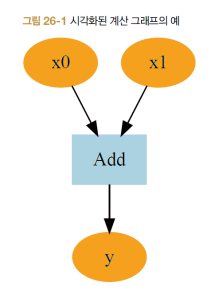

## dot_var 함수
▪ get_dot_graph 함수 전용으로 로컬에서만 사용함

▪ Variable 인스턴스를 건네면 인스턴스 내용을 DOT 언어로 작성된 문자열로 바꿔서 변환

▪ 변수 노드에 고유한 ID를 부여하기 위해 파이썬 내장 함수인 id를 사용

▪ id 함수에서 반환하는 객체 ID는 다른 객체와 중복되지 않아서 노드의 ID로 사용하기 적합

▪ format 메서드 문자열의 “{ }” 부분을 인수로 건넨 객체로 차례로 바꿔줌

In [ ]:
def _dot_var(v, verbose=False):
  dot_var = '{} [label="{}", color = orange, style = filled]\n'

  name = '' if v.name is None else v.name
  if verbose and v.data is not None:
    if v.name is not None:
      name +=': '
  return dot_var.format(id(v), name)

In [ ]:
x = Variable(np.random.randn(2,3))
x.name = 'x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))

140181337158320 [label="x", color = orange, style = filled]

140181337158320 [label="x: ", color = orange, style = filled]



## _dot_func 함수

▪ get_dot_graph 함수 전용으로 로컬에서만 사용함

▪ DeZero 함수를 DOT 언어로 기술

▪ 함수와 입력 변수의 관계, 함수와 출력 변수의 관계도 DOT 언어로 기술함

▪ DeZero 함수는 Function 클래스를 상속하고, inputs와 outputs라는 인스턴스 변수를 가짐

In [ ]:
def _dot_func(f):
  dot_func = '{} [label="{}", color = lightblue, style = filled, shape=box]\n'
  ret = dot_func.format(id(f), f.__class__.__name__)

  dot_edge = '{} -> {}\n'
  for x in f.inputs:
    ret += dot_edge.format(id(x), id(f))
  for y in f.outputs:
    ret += dot_edge.format(id(f), id(y()))
  return ret

In [ ]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1
txt = _dot_func(y.creator)
print(txt)

140181337408128 [label="Add", color = lightblue, style = filled, shape=box]
140181337415376 -> 140181337408128
140181337412112 -> 140181337408128
140181337408128 -> 140181337417824



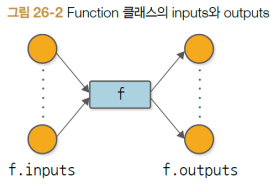

## get_dot_graph 함수
▪Variable 클래스의 backward 메서드와 거의 같음

▪ backward 메서드는 미분값을 전파 -> 미분 대신 DOT 언어로 기술한 문자열 txt에 추가

▪ 역전파는 노드를 따라가는 순서가 중요하여 함수에 generation 정수값 부여

▪ 노드를 추적하는 순서는 필요없어 generation 값으로 정력하는 코드는 주석 처리


In [ ]:
def get_dot_graph(output, verbose=True):
  txt = ''
  funcs = []
  seen_set = set()

  def add_func(f):
    if f not in seen_set:
      funcs.append(f)
      # funcs.sort(key=lambda x : x.generation)
      seen_set.add(f)

  add_func(output.creator)
  txt +=_dot_var(output, verbose)
  while funcs:
    func = funcs.pop()
    txt += _dot_func(func)
    for x in func.inputs:
      txt += _dot_var(x,verbose)

      if x.creator is not None:
        add_func(x.creator)
  return 'digraph g {\n' + txt + '}'


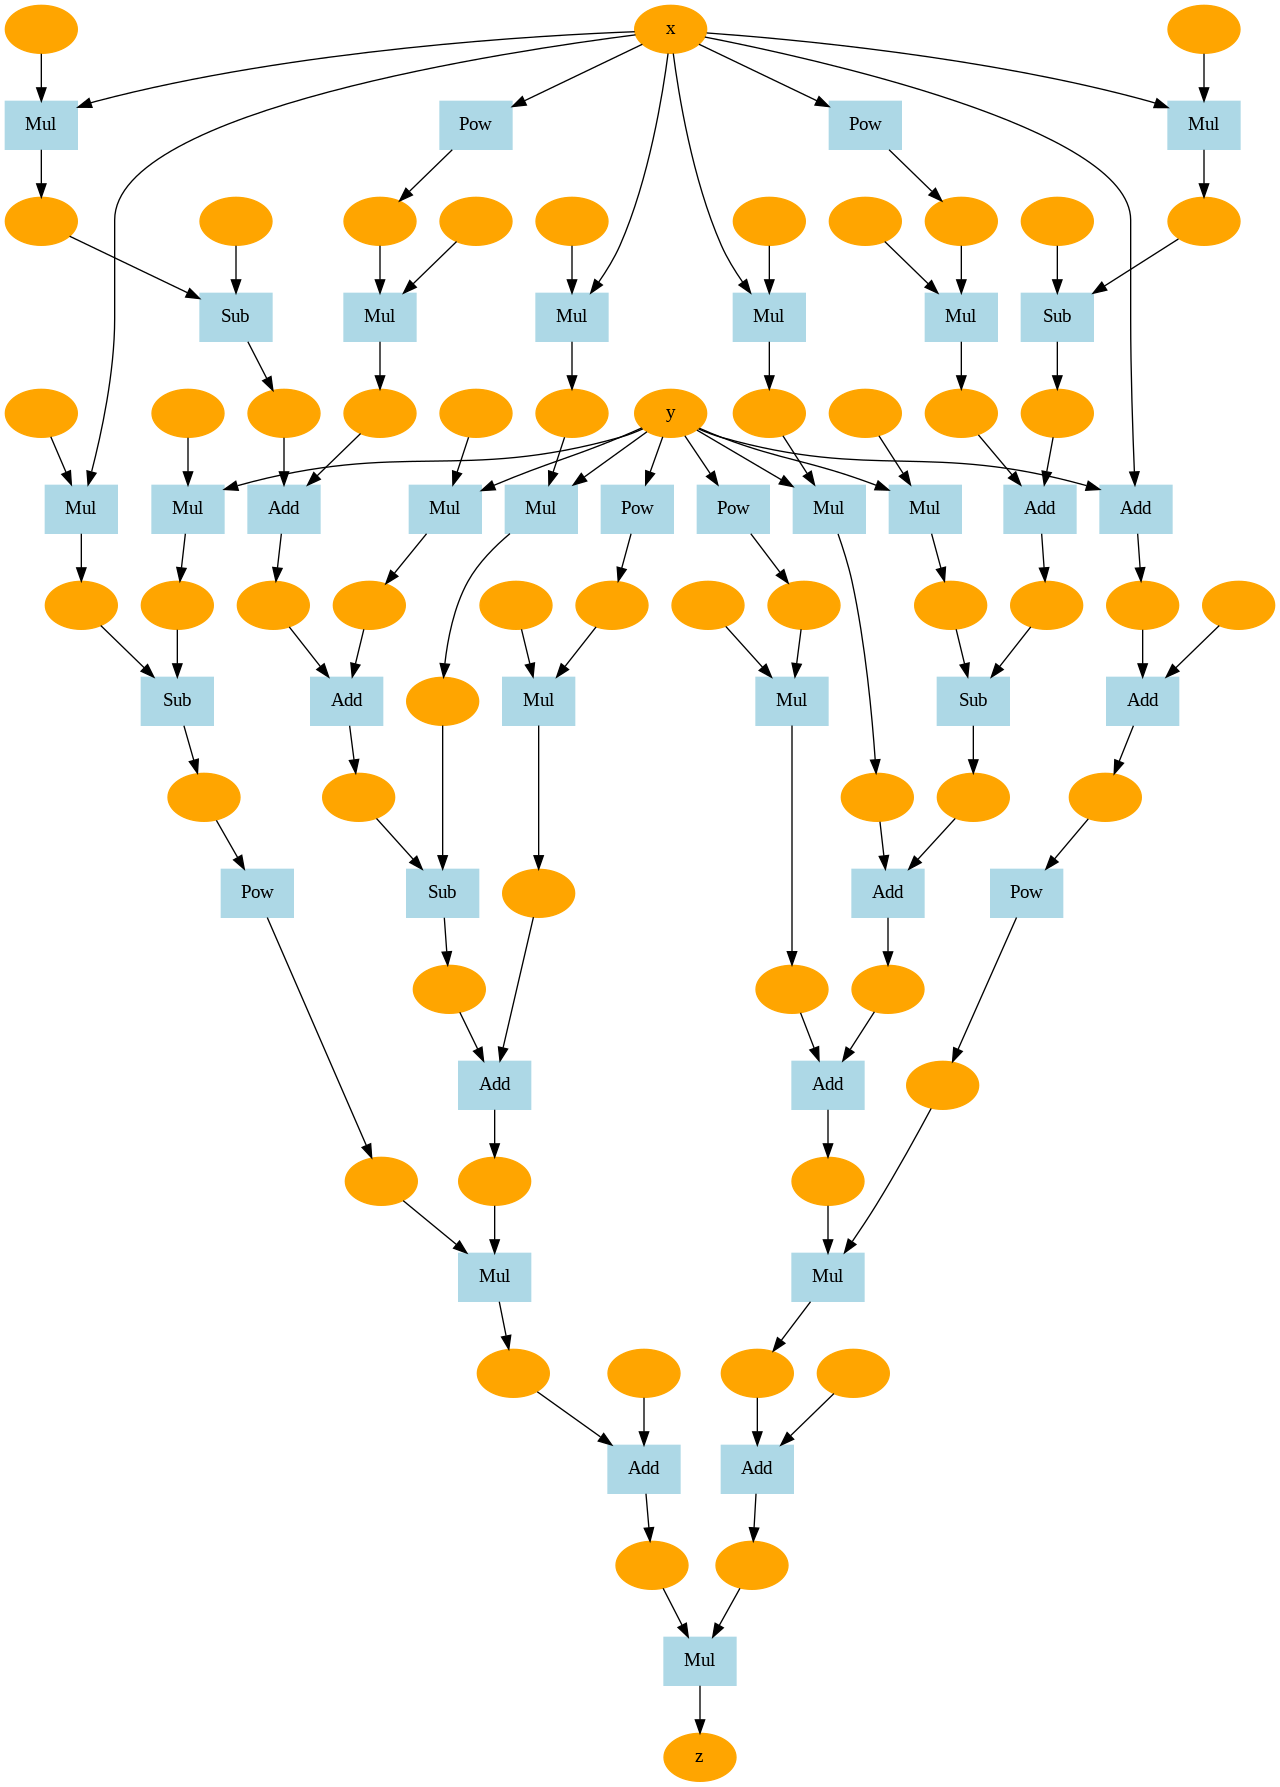

In [ ]:
from dezero.utils import plot_dot_graph
x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x,y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file = 'goldstein.png')

## 테일러 급수 미분

테일러 급수란?

- 어떤 미지의 함수를 동일한 미분계수를 갖는 어떤 다항함수로 근사시키는 것

- 테일러 급수가 필요한 이유는 잘 모르거나 복잡한 함수를 다루기 쉽고 이해하기 쉬운 다항함수로 대체시키기 위함



## Sin 함수

In [ ]:
from dezero import Variable, Function

class Sin(Function):
  def forward(self, x):
    y = np.sin(x)
    return y

  def backward(self, gy):
    x = self.input[0].data
    gx = gy * np.cos(x)
    return gx

def sin(x):
  return Sin()(x)

## 테일러 급수 sin 함수 구현

• threshold로 근사치의 정밀도를 조정

- 임곗값을 threshold로 지정, threshold 가 작을수록 정밀도가 높아짐
-  t의 절대값이 threshold 보다 낮아지면 for 문을 빠져나오게 함

In [ ]:
import math
def my_sin(x, threshold = 0.0001):
  y = 0
  for i in range(100000):
    c = (-1) ** i / math.factorial(2*i+1)
    t = c * x ** (2*i+1)
    y = y + t
    if abs(t.data) < threshold:
      break
    return y

## 로젠브록 함수의 미분

▪ (𝒙𝟎, 𝒙𝟏) = (0.0, 2.0) 에서의 미분 (𝒙′
𝟎 와 𝒙′
𝟏) 계산

▪ 수치 데이터를 Variable로 감싸서 건네주고 그 다음은 수식을 따라 코딩

▪ 𝒙𝟎 과 𝒙𝟏의 미분은 각각 -2.0과 400.0이 나옴

▪ (-2.0, 400.0) 벡터를 기울기 혹은 기울기 벡터라고 함

▪ 기울기는 각 지점에서 함수의 출력을 가장 크게 하는 방향을 가르킴

▪ (𝒙𝟎, 𝒙𝟏) = (0.0, 2.0) 지점에서 y값을 가장 크게 늘려주는 방향이 (-2.0, 400.0) 이라는 의미

▪ 반대로 기울기에 마이너스를 곱한 (2.0, -400.0) 방향은 y 값을 가장 작게 줄여주는 방향

In [ ]:
def rosenbrock(x0,x1):
  y = 100 * (x1 - x0 **2) **2 +(x0 - 1) **2
  return y

## 경사하강법
▪ 복잡한 형상의 함수라면 기울기가 가리키는 방향에 반드시 최솟값이 존재하지는 않음

▪ 국소적으로 보면 기울기는 함수의 출력을 가장 크게 하는 방향을 나타냄

▪ 기울기 방향으로 일정 거리만큼 이동하여 다시 기울기를 구하는 작업을 반복하면 점차 최
솟값(혹은 최댓값)에 접근하리라 기대할 수 있음

▪ 좋은 초깃값은 경사하강법을 목적지까지 효율적으로 도달하게 함


## 로젠브록 함수의 최솟값

▪ 기울기 방향에 마이너스를 곱한 방향으로 이동함

▪ iters 는 반복횟수, lr 은 학습률은 말함

▪ cleargrad 메서드

• x0.grad, x1.grad 는 미분값이 누적되기 때문에 새롭게 미분할 때는 누적된 값을 초기화 해야함

▪ 코드를 실행해보면 (x0, x1) 값이 갱신되는 과정을 볼수 있음

In [ ]:
# ▪ 반복횟수 iters = 1000
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 1000

for i in range(iters):
  print(x0,x1)

  y = rosenbrock(x0, x1)

  x0.cleargrad()
  x1.cleargrad()
  y.backward()

  x0.data -= lr * x0.grad
  x1.data -= lr * x1.grad

In [ ]:
# ▪ 반복횟수 iters = 10000
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 10000

for i in range(iters):
  print(x0,x1)

  y = rosenbrock(x0, x1)

  x0.cleargrad()
  x1.cleargrad()
  y.backward()

  x0.data -= lr * x0.grad
  x1.data -= lr * x1.grad

In [ ]:
# ▪ 반복횟수 iters = 50000
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 5000

for i in range(iters):
  print(x0,x1)

  y = rosenbrock(x0, x1)

  x0.cleargrad()
  x1.cleargrad()
  y.backward()

  x0.data -= lr * x0.grad
  x1.data -= lr * x1.grad

iters 값이 커질수록 최솟값에 더욱 가까워짐

## 뉴턴 방법을 활용한 최적화 이론



In [ ]:
def f(x):
  y = x ** 4 - 2 * x **2
  return y

def gx2(x):
  return 12 * x **2 -4

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
  print(i, x)

  y = f(x)
  x.cleargrad()
  y.backward()

  x.data -=x.grad / gx2(x.data)

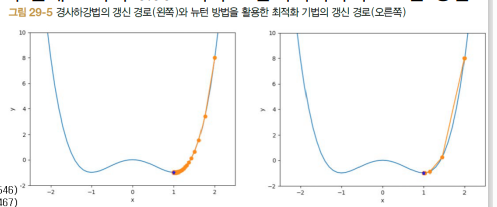